In [43]:
import tensorflow as tf

print(tf.__version__) 

2.18.0


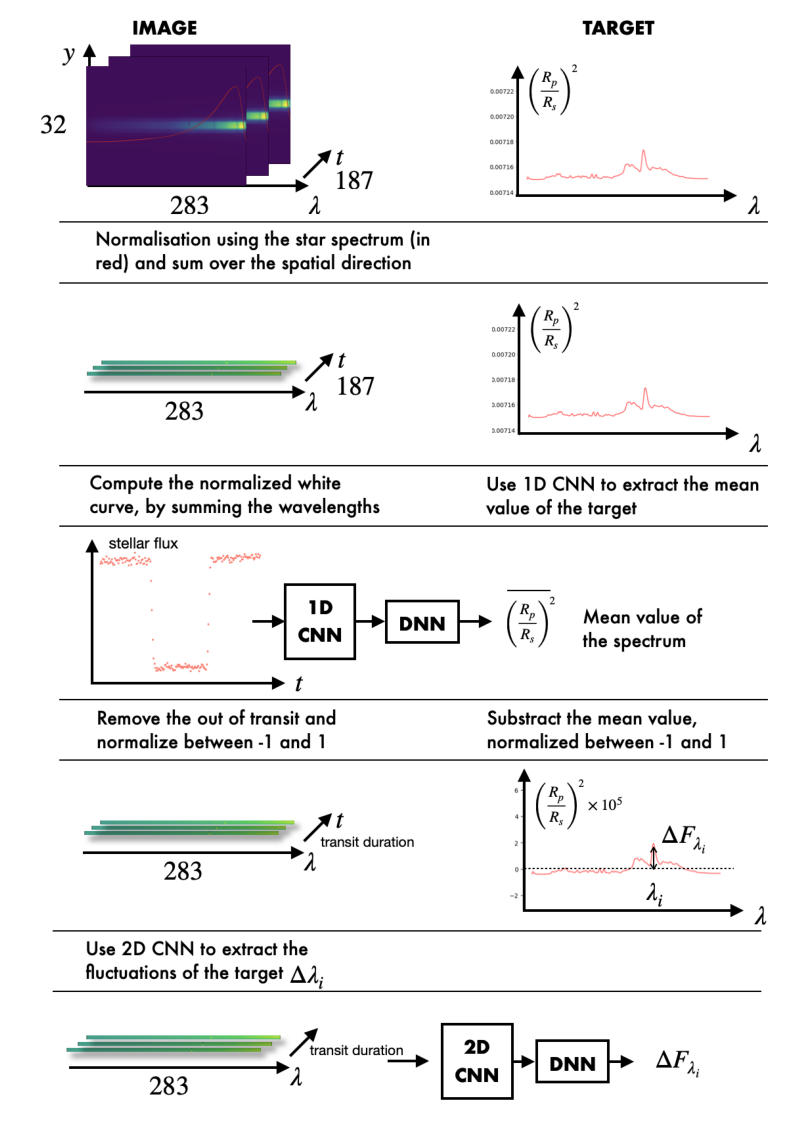

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('./input/baseline-img/2nd_baseline.png')
plt.figure(figsize=(10, 15))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf 
import random 
import os
from tensorflow.keras.losses import MeanAbsoluteError
from matplotlib.ticker import ScalarFormatter
import pandas as pd

/Users/kevin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
data_folder = './input/binned-dataset-v3/' # path to the folder containing the data
auxiliary_folder = './input/ariel-data-challenge-2024/' # path to the folder containing the train targets and wavelengths informations

In [4]:
data_train = np.load(f'{data_folder}/data_train.npy')
data_train_FGS = np.load(f'{data_folder}/data_train_FGS.npy')

In [5]:
print(data_train.shape)

(673, 187, 282, 32)


In [6]:
print(data_train_FGS.shape)

(673, 187, 32, 32)


In [7]:
output_dir = './output'

SEED = 42

do_the_mcdropout_wc = True
do_the_mcdropout = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

Directory ./output already exists.


In [8]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)
print(f'train_solution.shape: {train_solution.shape}')
targets = train_solution[:,1:]
print(f'targets.shape: {targets.shape}')
targets_mean = targets[:,1:].mean(axis = 1) # used for the 1D-CNN to extract the mean value, only AIRS wavelengths as the FGS point is not used in the white curve
print(f'targets_mean.shape: {targets_mean.shape}')
N = targets.shape[0]
print(f'targets.shape[0]: {targets.shape[0]}')


train_solution.shape: (673, 284)
targets.shape: (673, 283)
targets_mean.shape: (673,)
targets.shape[0]: 673


In [9]:
signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned  = data_train, data_train_FGS
print(f'data_train.shape: {data_train.shape}')
print(f'signal_AIRS_diff_transposed_binned.shape: {signal_AIRS_diff_transposed_binned.shape}')
print(f'data_train_FGS.shape: {data_train_FGS.shape}')
print(f'signal_FGS_diff_transposed_binned.shape: {signal_FGS_diff_transposed_binned.shape}')

FGS_column = signal_FGS_diff_transposed_binned.sum(axis = 2)
dataset = np.concatenate([signal_AIRS_diff_transposed_binned, FGS_column[:,:, np.newaxis,:]], axis = 2)

data_train.shape: (673, 187, 282, 32)
signal_AIRS_diff_transposed_binned.shape: (673, 187, 282, 32)
data_train_FGS.shape: (673, 187, 32, 32)
signal_FGS_diff_transposed_binned.shape: (673, 187, 32, 32)


In [10]:
dataset = dataset.sum(axis=3)


In [11]:
def create_dataset_norm(dataset1, dataset2) :
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2


def norm_star_spectrum (signal) : 
    img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
    return signal/img_star[:,np.newaxis,:]

dataset_norm = norm_star_spectrum(dataset)
dataset_norm = np.transpose(dataset_norm,(0,2,1))

In [12]:
cut_inf, cut_sup = 39, 321 # we have previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data file
l = cut_sup - cut_inf + 1 
wls = np.arange(l)


def split (data, N) : 
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets : 
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1

N_train = 8*N//10

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

In [13]:
signal_AIRS_diff_transposed_binned = signal_AIRS_diff_transposed_binned.sum(axis=3)
wc_mean = signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1)
white_curve = signal_AIRS_diff_transposed_binned.sum(axis=2)/ wc_mean[:, np.newaxis]

def normalise_wlc(train, valid) :

    wlc_train_min = train.min()
    wlc_train_max = train.max()
    
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)
    
    return train_norm, valid_norm

def normalize (train, valid) : 
    max_train = train.max()
    min_train = train.min()
    test_train = train
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)
    return train_norm, valid_norm, min_train, max_train

# Split the light curves and targets 
train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]

# Normalize the wlc
train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# Normalize the targets 
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc, valid_targets_wc)

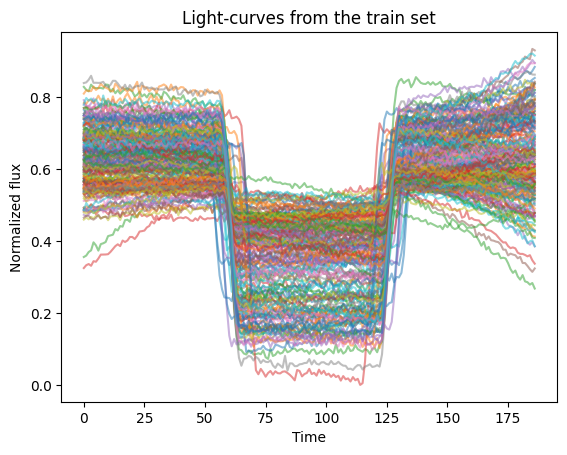

In [14]:
plt.figure()
for i in range (200) : 
    plt.plot(train_wc[-i], '-', alpha = 0.5)
plt.title('Light-curves from the train set') 
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate,AveragePooling1D
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint


input_wc = Input((187,1))
x = Conv1D(32, 3, activation='relu')(input_wc)
x = MaxPooling1D()(x)
x = BatchNormalization() (x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, activation='relu')(x)
# add this layer
# x = MaxPooling1D()(x)
# x = Conv1D(512, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(512, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x, training = True)
output_wc = Dense(1, activation='linear')(x)

model_wc = Model(inputs=input_wc, outputs=output_wc)
model_wc.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 92, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 90, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 19, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 7, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,228,673 (8.50 MB)

 Trainable params: 2,228,609 (8.50 MB)

 Non-trainable params: 64 (256.00 B)

In [33]:
def scheduler(epoch, lr):
    decay_rate = 0.2
    decay_step = 200  
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

optimizer = SGD(0.001)
model_wc.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])
callback = LearningRateScheduler(scheduler)
checkpoint_filepath = 'output/model_1dcnn.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

print('Running ...')
history = model_wc.fit(
    x = train_wc,  
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),  
    batch_size=16,
    epochs= 1200,
    shuffle=True,
    verbose=0, 
    callbacks=[model_ckt]
    )
print('Done.')

Running ...
Done.


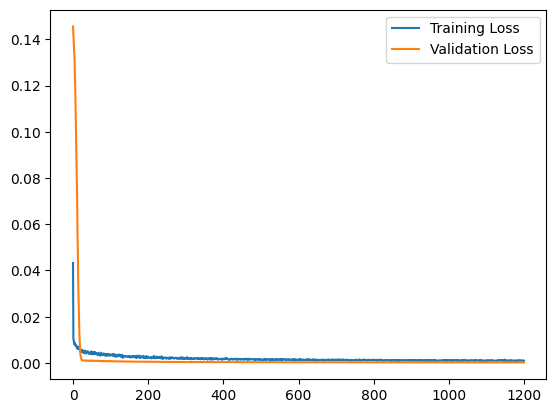

In [34]:
model_wc = load_model(checkpoint_filepath)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [35]:
nb_dropout_wc = 1000

def unstandardizing (data, min_train_valid, max_train_valid) : 
    return data * (max_train_valid - min_train_valid) + min_train_valid

def MC_dropout_WC (model, data, nb_dropout) : 
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout) : 
        predictions[i,:] = model.predict(data, verbose = 0).flatten()
    return predictions

if do_the_mcdropout_wc :
    print('Running ...')
    prediction_valid_wc = MC_dropout_WC(model_wc, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all = unstandardizing(prediction_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc, spectre_valid_std_wc = spectre_valid_wc_all.mean(axis = 0), spectre_valid_wc_all.std(axis = 0)
    print('Done.')

else : 
    spectre_valid_wc = model_wc.predict(valid_wc).flatten()
    spectre_valid_wc = unstandardizing(spectre_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc = 0.1*np.abs(spectre_valid_wc)

Running ...
Done.


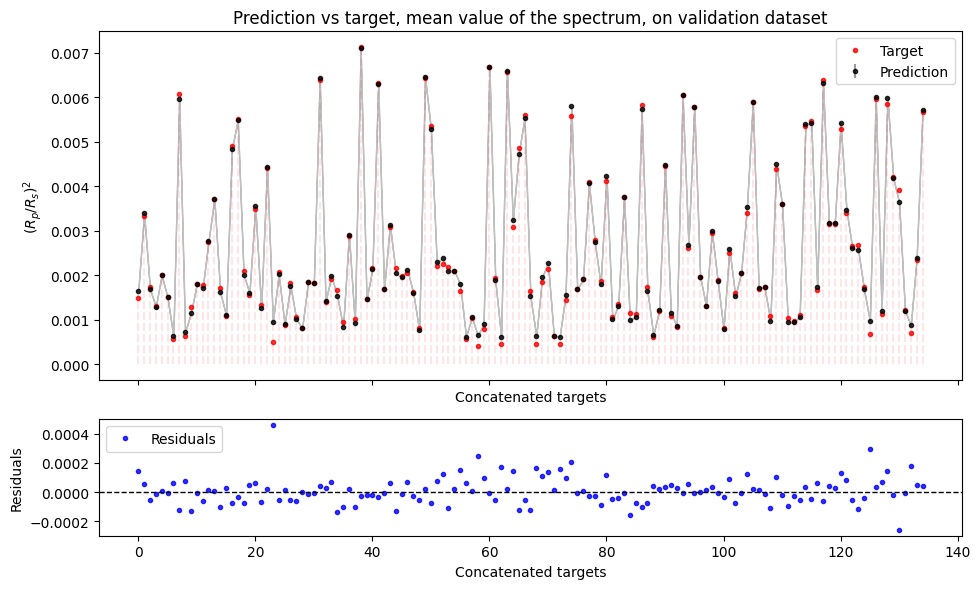

In [37]:
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(x = np.arange(len(spectre_valid_wc)), y = spectre_valid_wc, yerr =spectre_valid_std_wc, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc)), spectre_valid_wc - spectre_valid_std_wc, spectre_valid_wc + spectre_valid_std_wc, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc)),ymin=0, ymax=spectre_valid_wc, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset')
ax1.legend()

ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()

plt.tight_layout()
plt.show()

In [38]:
residuals = valid_targets_wc - spectre_valid_wc
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  94.0371106086281 ppm


In [41]:
np.save(f'{output_dir}/pred_valid_wc.npy', spectre_valid_wc)
np.save(f'{output_dir}/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/std_valid_wc.npy', spectre_valid_std_wc)

In [42]:
def suppress_mean(targets, mean) : 
    res = targets - np.repeat(mean.reshape((mean.shape[0], 1)), repeats = targets.shape[1], axis = 1)
    return res
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

train_targets_shift = suppress_mean(train_targets,  targets_mean[list_index_train])
valid_targets_shift = suppress_mean(valid_targets,  targets_mean[~list_index_train])

In [43]:
##### normalization of the targets ###
def targets_normalization (data1, data2) : 
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max

def targets_norm_back (data, data_abs_max) : 
    return data * data_abs_max

train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(train_targets_shift, valid_targets_shift)

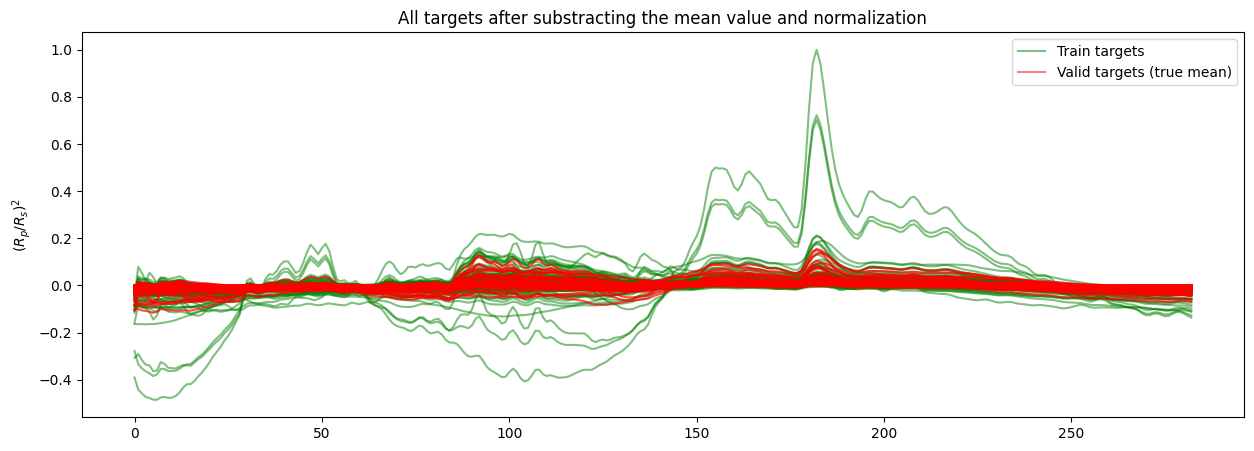

In [44]:
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets_norm[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) : 
    plt.plot(wls, valid_targets_norm[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('All targets after substracting the mean value and normalization')
plt.show()

In [45]:
###### Transpose #####
train_obs = train_obs.transpose(0, 2, 1)
valid_obs = valid_obs.transpose(0, 2, 1)
print(train_obs.shape)

(538, 187, 283)


In [46]:
##### Substracting the out transit signal #####
def suppress_out_transit (data, ingress, egress) : 
    data_in = data[:, ingress:egress,:]
    return data_in

ingress, egress = 75,115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)

In [47]:
###### Substract the mean #####
def substract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean

train_obs_2d_mean = substract_data_mean(train_obs_in)
valid_obs_2d_mean = substract_data_mean(valid_obs_in)

In [48]:
##### Normalization dataset #####
def data_norm(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max


def data_normback(data, data_abs_max) : 
    return data * data_abs_max

train_obs_norm, valid_obs_norm, data_abs_max = data_norm(train_obs_2d_mean, valid_obs_2d_mean)

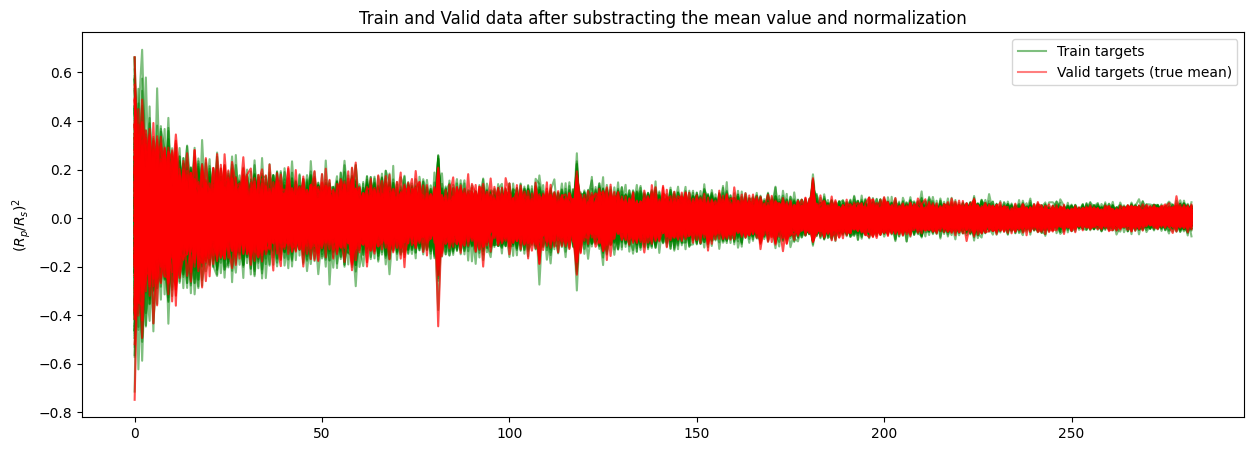

In [49]:
plt.figure(figsize=(15,5))
for i in range (train_obs.shape[0]) :
    plt.plot(wls, train_obs_norm[i,10], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (valid_obs.shape[0]) : 
    plt.plot(wls, valid_obs_norm[i,10], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Train and Valid data after substracting the mean value and normalization')
plt.show()

In [ ]:
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Reshape, Dropout, BatchNormalization, AveragePooling2D
from keras.models import Model
import tensorflow as tf
import numpy as np

## CNN 2 global normalization data
input_obs = Input((40,283,1))
x = Conv2D(32, (3, 1), activation='relu', padding='same')(input_obs)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(128, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(256, (3, 1), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(128, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(256, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Flatten()(x)
# DNN
# 12/11/2024 change from Dense(700, activation='relu')(x) to Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
output = Dense(283, activation='linear')(x)

model = Model(inputs=[input_obs], outputs=output)

checkpoint_filepath = 'output/model_2dcnn.keras'
model_ckt2 = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)
model.compile(optimizer=Adam(0.001), loss='mse', metrics=[MeanAbsoluteError()])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 40, 283, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 40, 283, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 283, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 20, 283, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 20, 283, 64)    │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 283, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 10, 283, 128)   │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 5, 283, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 5, 283, 256)    │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 5, 283, 32)     │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 141, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 5, 141, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 5, 141, 64)     │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 5, 70, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 5, 70, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 35, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 35, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 17, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 21760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │    22,283,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 283)            │       290,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,857,275 (87.19 MB)

 Trainable params: 22,857,147 (87.19 MB)

 Non-trainable params: 128 (512.00 B)

In [54]:
history = model.fit(
     x = train_obs_norm,  
     y = train_targets_norm,
     validation_data = (valid_obs_norm, valid_targets_norm),  
     batch_size=32,
     epochs= 200,
     shuffle=True,
     verbose=0,
    callbacks=[model_ckt2]
 )

/Users/kevin/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_256']. Received: the structure of inputs=*
  warnings.warn(


In [55]:
nb_dropout = 5

def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model.predict([x_test],verbose=0)
        pred = targets_norm_back(pred_norm, targets_abs_max)
        predictions += [pred]  
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout :
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainity(model, [valid_obs_norm], targets_abs_max, T = nb_dropout)
    
else :

    pred_valid_norm = model.predict([valid_obs_norm])
    pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
    spectre_valid_shift = pred_valid
    spectre_valid_shift_std = spectre_valid_shift*0.1

/Users/kevin/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_256']. Received: the structure of inputs=(('*',),)
  warnings.warn(


In [56]:
residuals = valid_targets_shift - spectre_valid_shift
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  36.16927884573779 ppm


In [57]:
np.save(f'{output_dir}/pred_valid_shift.npy', spectre_valid_shift)
np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_shift)
np.save(f'{output_dir}/std_valid_shift.npy', spectre_valid_shift_std)

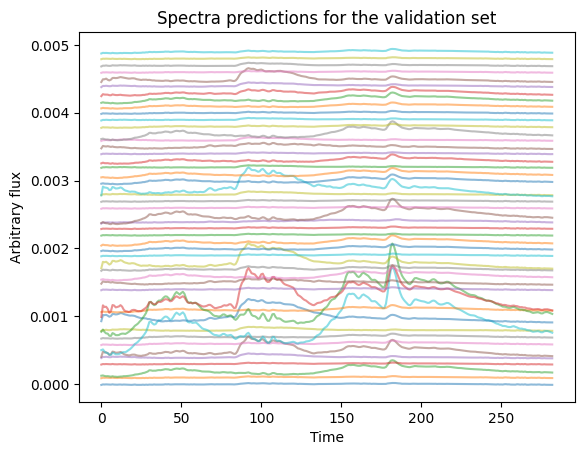

In [58]:
plt.figure()
for i in range (50) : 
    plt.plot(spectre_valid_shift[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set') 
plt.xlabel('Time')
plt.ylabel('Arbitrary flux')
plt.show()

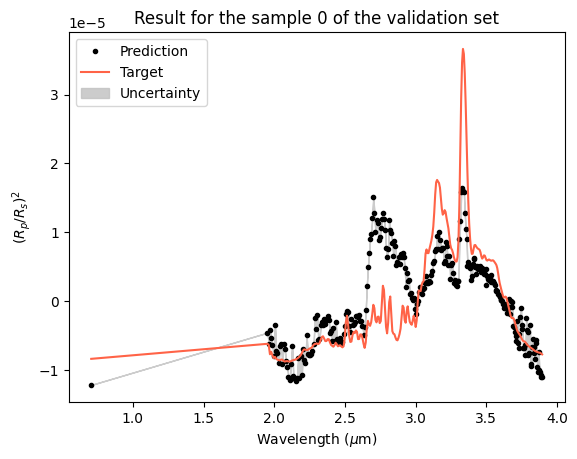

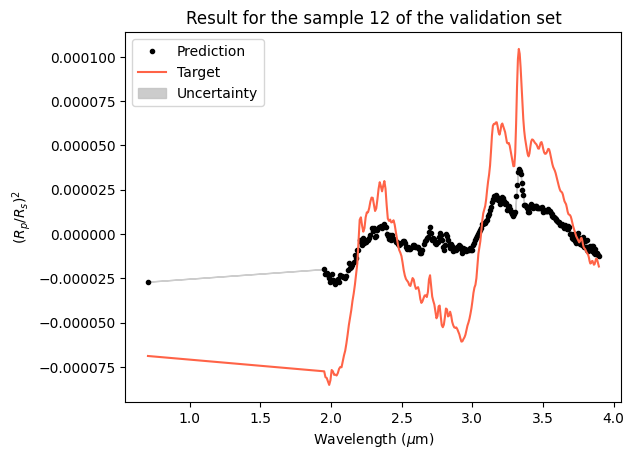

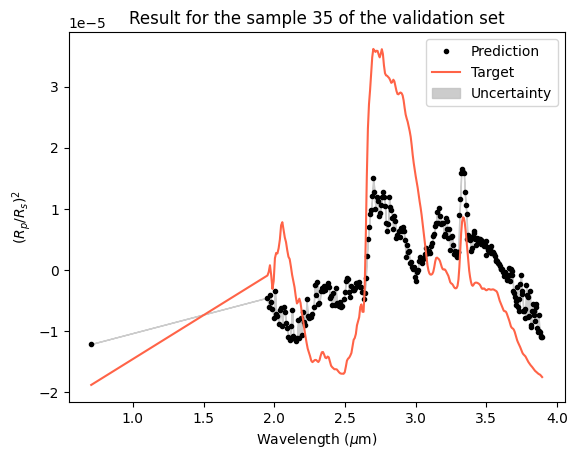

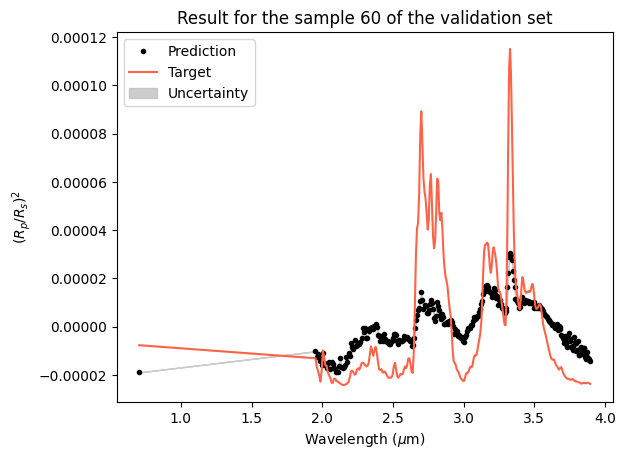

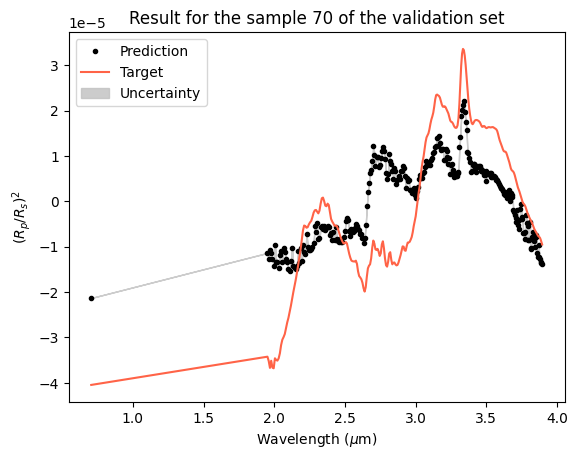

In [59]:
list_valid_planets = [0, 12, 35, 60, 70]
wavelength = np.loadtxt('./input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter = ',')
uncertainty = spectre_valid_shift_std
for i in (list_valid_planets):
    plt.figure()
    plt.title('Result for the sample {} of the validation set'.format(i))
    plt.plot(wavelength, spectre_valid_shift[i], '.k', label = 'Prediction')
    plt.plot(wavelength, valid_targets_shift[i], color = 'tomato', label = 'Target')
    plt.fill_between(wavelength, spectre_valid_shift[i] - spectre_valid_shift_std[i], spectre_valid_shift[i] + spectre_valid_shift_std[i], color='silver', alpha = 0.8, label = 'Uncertainty')
    plt.legend()
    plt.ylabel(f'$(R_p/R_s)^2$')
    plt.xlabel(f'Wavelength ($\mu$m)')
    plt.show()


In [60]:
######## ADD THE FLUCTUATIONS TO THE MEAN ########
def add_the_mean (shift, mean) : 
    return shift + mean[:,np.newaxis]

predictions_valid = add_the_mean(spectre_valid_shift,spectre_valid_wc)

predictions_std_valid = np.sqrt(spectre_valid_std_wc[:,np.newaxis]**2 + spectre_valid_shift_std**2)

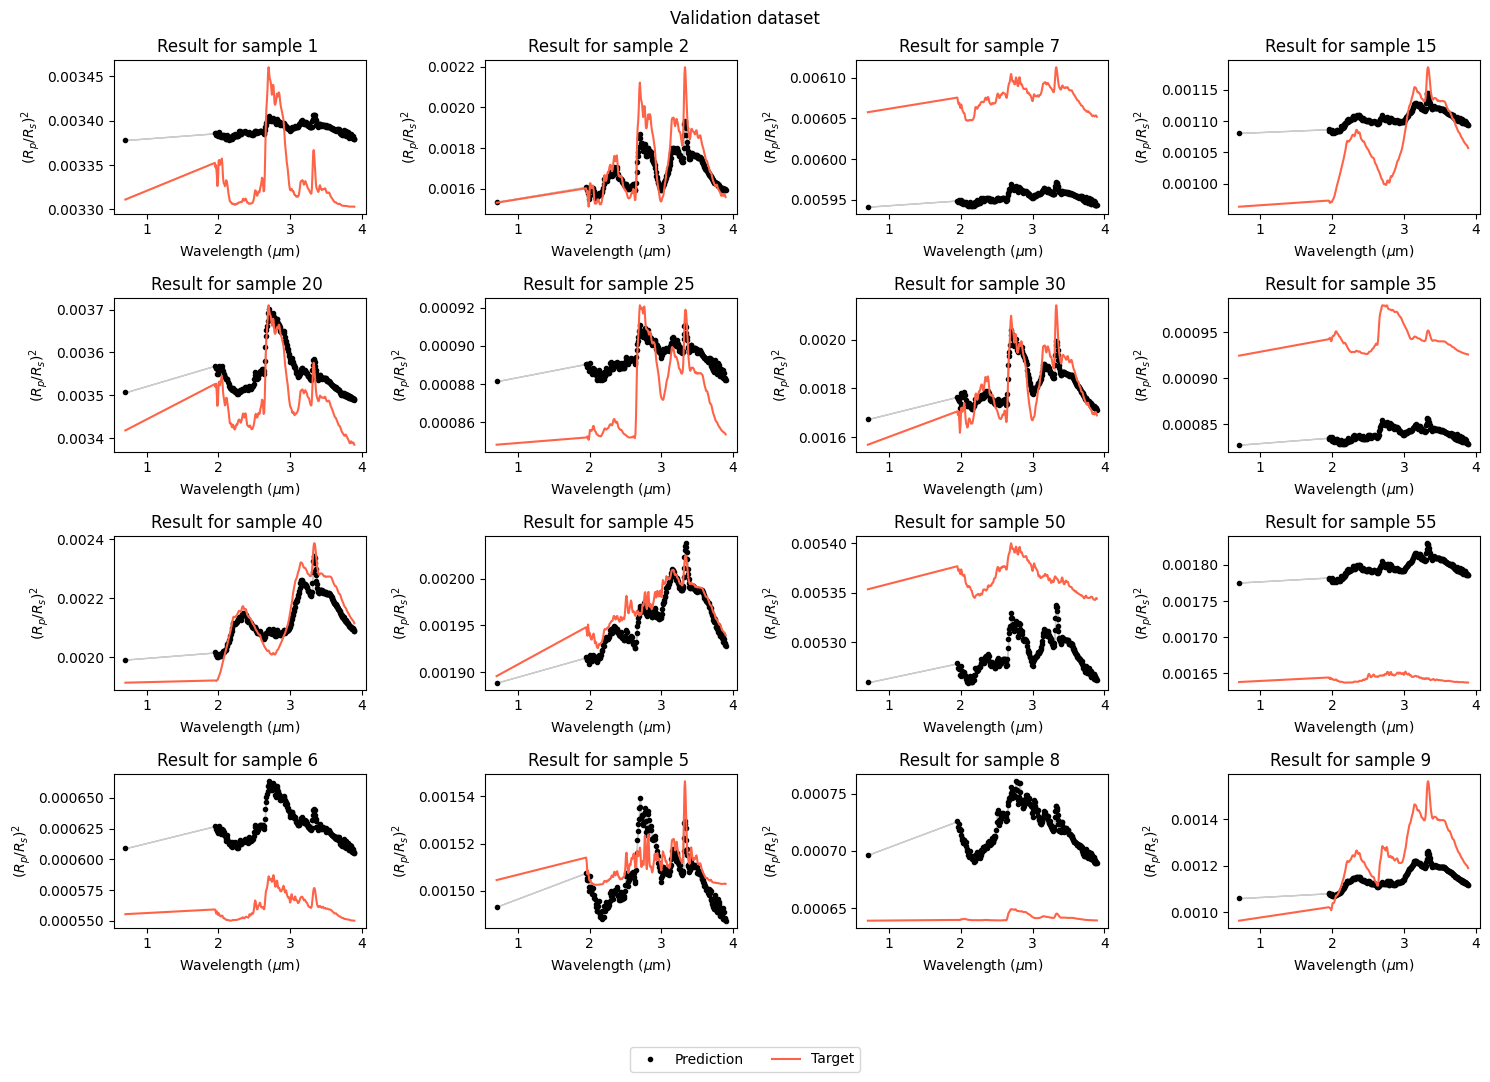

In [61]:
uncertainty = predictions_std_valid

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength, predictions_valid[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength, valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength, predictions_valid[p, :] - uncertainty[p], predictions_valid[p, :] + uncertainty[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Validation dataset')
plt.tight_layout()
plt.show()

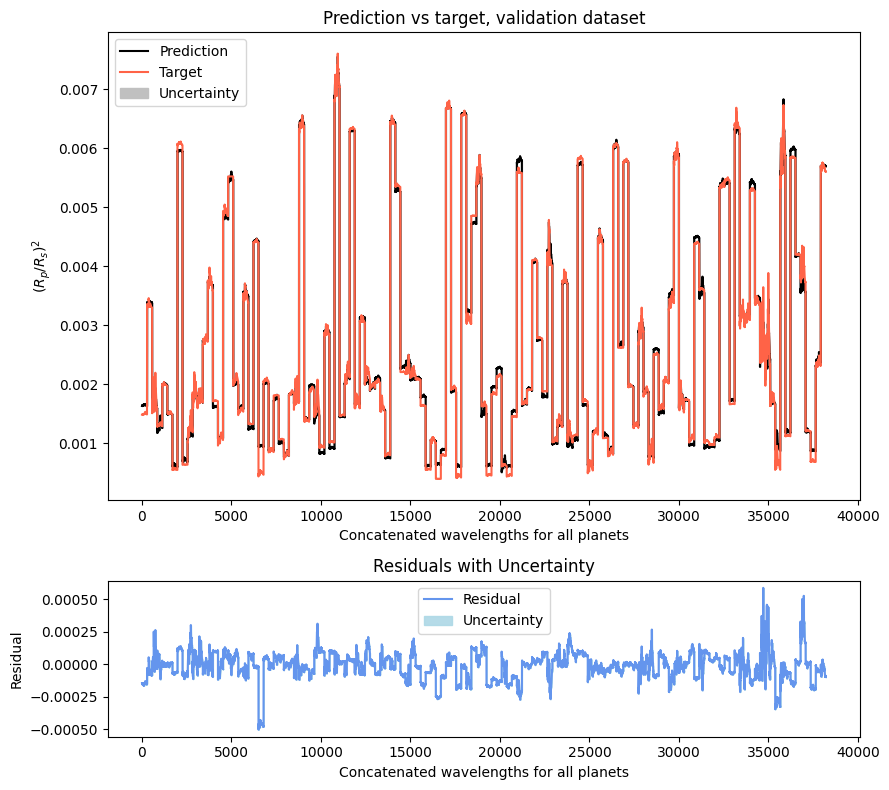

MSE :  100.76584651956779 ppm


In [63]:
######## PLOTS THE RESULT ########
predictions = predictions_valid
targets_plot = valid_targets
std = predictions_std_valid

predictions_concatenated_plot = np.concatenate(predictions, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)
spectre_valid_std_concatenated = np.concatenate(std, axis=0)
residuals = targets_concatenated_plot - predictions_concatenated_plot
uncertainty = spectre_valid_std_concatenated

fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)), 
                    predictions_concatenated_plot - uncertainty, 
                    predictions_concatenated_plot + uncertainty, 
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)), 
                    residuals - uncertainty, 
                    residuals + uncertainty, 
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()

print('MSE : ',np.sqrt((residuals**2).mean())*1e6, 'ppm')

In [42]:
np.save(f'{output_dir}/pred_valid.npy', predictions_valid)
np.save(f'{output_dir}/std_valid.npy', predictions_std_valid)